<a href="https://colab.research.google.com/github/denisecammarota/matbio/blob/master/tp5/P5_Ej2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 5 - Ejercicio 2**: *Epidemia de covid-19*
***Matemática de los Sistemas Biológicos - 2021***

**Alumna**: Denise S. Cammarota

In [134]:
#@title 
#importo librerías que me van a ser útiles en hacer las simulaciones
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
plt.style.use('seaborn')

En este ejercicio, nos piden analizar los datos de la pandemia de Covid-19 en Argentina, con los datos que se pueden bajar del siguiente link: [datos](https://drive.google.com/file/d/1vtyItbk4Nuv7aKSKs6NnnTxVTsDfInf_/view). Estos datos incluyen el número de infectados reportados, muertos, cuidados UCI ocupados y tests realizados para una fecha determinada. 

**Aclaración**: Para el correcto funcionamiento de este notebook, se tienen que cargar los datos mencionados al runtime en uso. 

### Gráfico de los datos de la pandemia y análisis preliminar

Primero, nos piden graficar los indicadores proveídos, y sacar conclusiones de estos gráficos. Estos son el número de infectados ($I_{t}$), de muertos ($M_{t}$), de cuidados UCI requeridos ($U_{t}$) y de tests realizados ($T_{t}$) para un día $t$ determinado. Contaremos los días a partir del primer día de reporte, que es el 5/03/20, que será considerado el día $t=0$. En caso de que falte un valor en cualquiera de las series temporales, se rellena correspondientemente con un cero. 

Observamos varias cosas a primera vista:

1.   Las series temporales son ruidosas, sobre todo las de infectados, muertos y tests realizados por día. Esto probablemente se debe a variaciones y retrasos en la carga de datos que se producen en el transcurso de la semana. 
2.   Lo mismo no sucede para el número de cuidados intensivos al día $t$. Esto tiene sentido si esta serie corresponde al número cuidados intensivos ocupados en un día determinado, y no a la cantidad de personas ingresadas ese día. Si fuera así, es razonable que sea menos ruidoso, ya que las personas que lo requieren generalmente permanecen varios días con cuidados intensivos. 
3.   Hay un día para el cual el número de muertos tiene un pico de alrededor de $3500$, lo cual no sucede en ningún otro momento. Se puede encontrar de una simple inspección de los datos que corresponde al día 1/10/20. Estos se deben a un día que el Ministerio de Salud cargó alrededor de $3000$ muertes pendientes, correspondientes a la provincia de Buenos Aires (como se puede ver en noticias como: [fuente](https://https://www.clarin.com/sociedad/argentina-supero-20-mil-muertes-coronavirus-sumo-14-001-nuevos-casos_0_4GOlsreAg.html)). Esto es algo que quizá podría solucionarse usando los datos del Ministerio de Salud (que se cargan todos los días en el siguiente [link](http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina)), donde consta la fecha de fallecimiento de las personas, independientemente del día del reporte. 
4.  Como es esperable, el número de tests realizados tiende a aumentar con el tiempo. 


In [135]:
#@title 
df = pd.read_table('covid.csv', sep=',')
df.fillna(0, inplace=True)
df = pd.DataFrame(df)
df = df.to_numpy()
fechas = df[:,0]
inf = df[:,1]
uci = df[:,2]
muer = df[:,3]
tests = df[:,4]

In [136]:
#@title 
#reemplazamos aca algunas cosas que están mal en los datos
filt_inf = np.where(inf == '#REF!')
inf[filt_inf] = 0
inf = inf.astype(float)
uci = uci.astype(float)
muer = muer.astype(float)
tests = tests.astype(float)

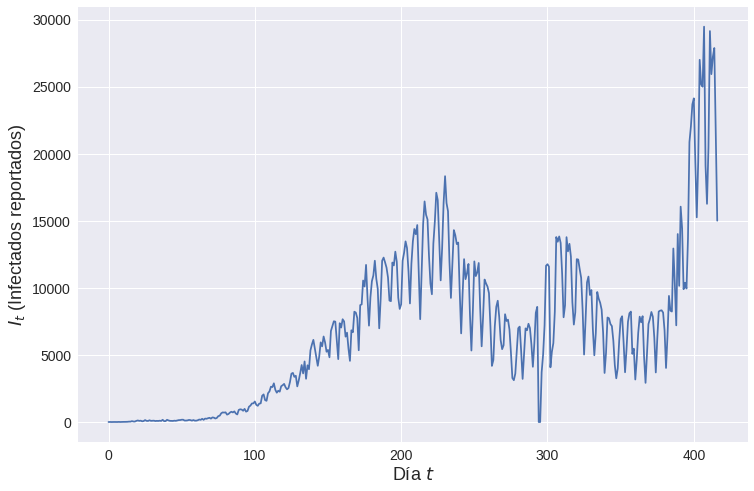

In [137]:
#@title 
fig = plt.figure(figsize=(12,8))
plt.plot(inf)
plt.xlabel('Día '+r'$t$',fontsize=18)
plt.ylabel(r'$I_{t}$'+' (Infectados reportados)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

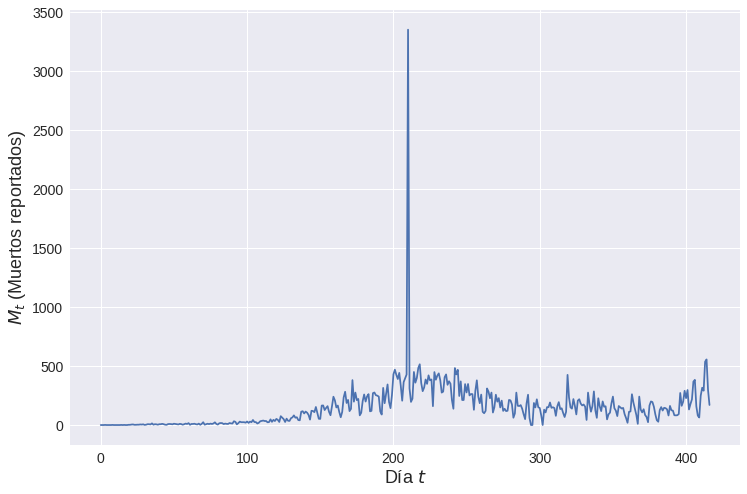

In [138]:
#@title 
fig = plt.figure(figsize=(12,8))
plt.plot(muer)
plt.xlabel('Día '+r'$t$',fontsize=18)
plt.ylabel(r'$M_{t}$'+' (Muertos reportados)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

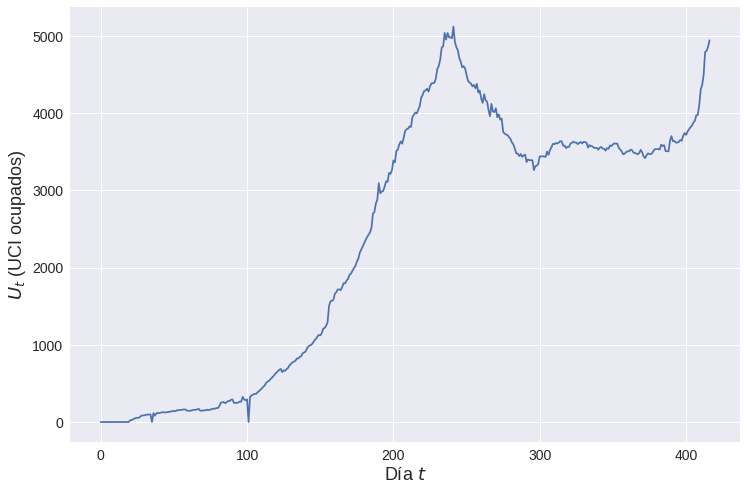

In [139]:
#@title 
fig = plt.figure(figsize=(12,8))
plt.plot(uci)
plt.xlabel('Día '+r'$t$',fontsize=18)
plt.ylabel(r'$U_{t}$'+' (UCI ocupados)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

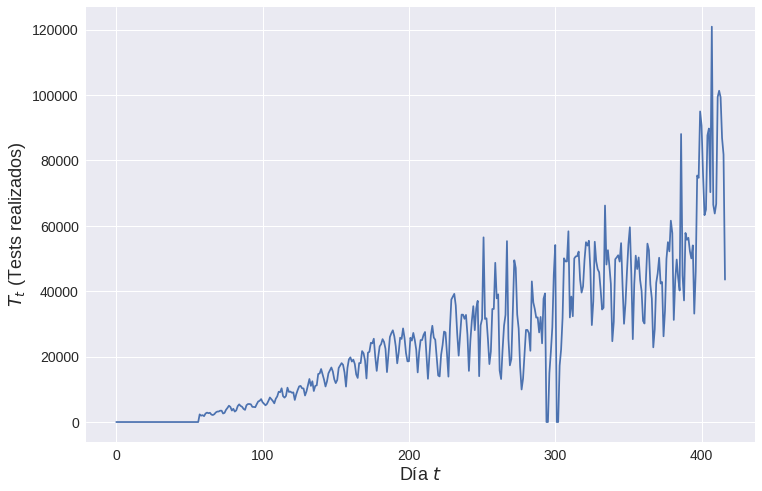

In [140]:
#@title 
fig = plt.figure(figsize=(12,8))
plt.plot(tests)
plt.xlabel('Día '+r'$t$',fontsize=18)
plt.ylabel(r'$T_{t}$'+' (Tests realizados)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

5.  Si graficamos la $I_{t} - T_{t}$, observamos que es generalmente negativo, con algunos picos positivos, lo cual nuevamente es una señal de retraso en la carga de datos. Si no hubiera tal retraso, no se explicaría que un día haya más casos nuevos que testeos realizados. 

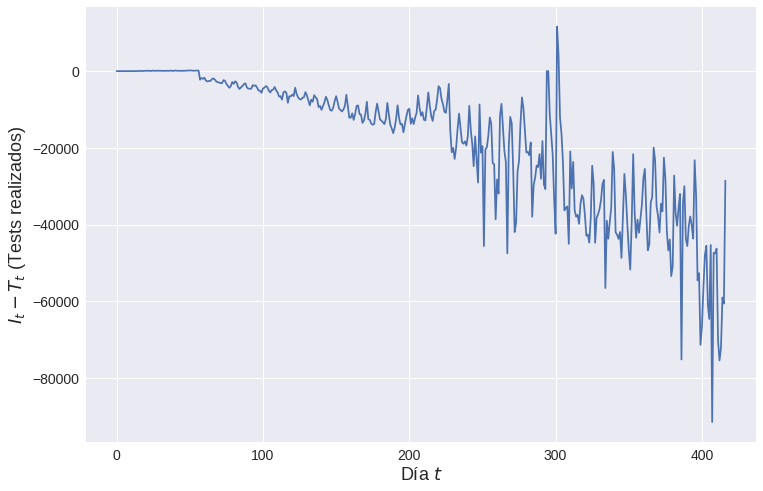

In [141]:
#@title 
fig = plt.figure(figsize=(12,8))
plt.plot(inf-tests)
plt.xlabel('Día '+r'$t$',fontsize=18)
plt.ylabel(r'$I_{t} - T_{t}$'+' (Tests realizados)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

6. Nos gustaría también observar relaciones temporales entre las distintas series temporales. Para ello, suavizamos con un suavizado lineal de Savitzky-Golay con una ventana de 7 días las series de infectados, muertos y cuidados UCI en función del tiempo. También, encontramos los picos más o menos definidos en las tres cantidades. En el caso de las muertes, no se señala un primer pico, dado que queda desdibujado por el elevado reporte del día 1/10/20. En el gráfico que sigue, dibujamos estas cantidades suavizadas y también normalizadas por el máximo valor que toman, para que sea más fácil una comparación entre las tres. 

7. En la primera ola, observamos que un pico en el número de casos es seguido por un pico en la cantidad de cuidados intensivos requeridos, como es esperable. Estos picos están separados por 11 días. Por el problema anterior, no podemos hacer algo análogo con las muertes.

8. En la segunda ola, correspondiente a las vacaciones de verano, no observamos un pico en la cantidad de cuidados intensivos requeridos. Esto es a pesar de que sí existen sendos máximos en la cantidad de muertos y de infectados. Probablemente, se debe a que la mayoría de las personas infectadas durante las vacaciones de verano fueron personas jóvenes que usualmente transitan la enfermedad sin mayores complicaciones. En cambio, observamos que un pico en la cantidad de fallecimientos que precede a un pico en el número de casos reportados por 12 días (un tiempo razonable considerando los tiempos característicos de la enfermedad). Consistente con el hecho de que la mayoría de las personas infectadas fueron jóvenes, el pico máximo en las muertes no alcanza los mismos niveles que durante la primera ola. 

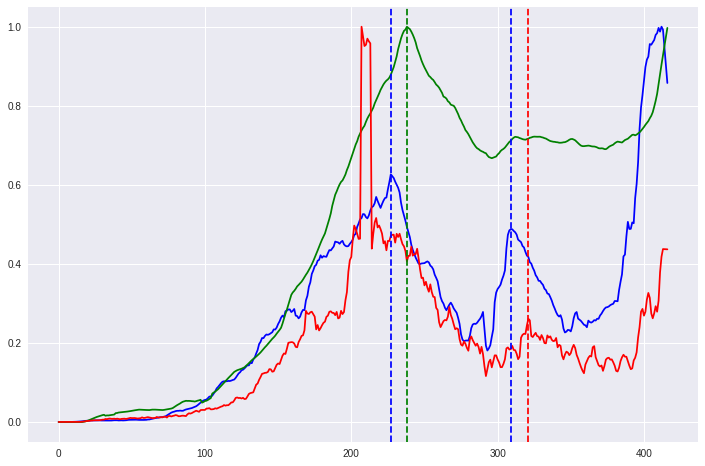

In [142]:
#@title 
fig = plt.figure(figsize=(12,8))
inf_s = savgol_filter(inf, 7, 1)
muer_s = savgol_filter(muer, 7, 1)
uci_s = savgol_filter(uci, 7, 1)
plt.plot(inf_s/max(inf_s),color='b')
plt.plot(uci_s/max(uci_s),color='g')
plt.plot(muer_s/max(muer_s),color='r')
max1_inf = np.argmax(inf_s[:250])
max2_inf = np.argmax(inf_s[280:350])+280
max1_uci = np.argmax(uci_s[:250])
max2_muer = np.argmax(muer_s[280:350])+280
plt.axvline(max1_inf,color='b',linestyle='--')
plt.axvline(max1_uci,color='g',linestyle='--')
plt.axvline(max2_inf,color='b',linestyle='--')
plt.axvline(max2_muer,color='r',linestyle='--')
plt.show()

### Ajuste de un modelo SIR

Luego de un primer análisis no preliminar de los datos, nos piden ajustar una modelo del tipo SIR a los datos en estudio. Para ello, nos piden utilizar distinta cantidad de puntos iniciales para el ajuste, y observar qué se puede decir del resto de la curva. Como vimos en ejemplos en clase, se nos pide ajustar a la cantidad de casos nuevos reportados por día una ecuación del tipo:

\begin{align}
a sech^{2} (bt + c)
\end{align}

Para realizar el ajuste, utilizaremos los datos suavizados de nuevos casos reportados $I_{t}$ al día $t$. 

In [179]:
def sech_sir(x,a,b,c):
  y = a*((np.cosh(b*x+c))**(-2))
  return y

In [193]:
inf_2 = inf[:200]
xdata = np.linspace(0,len(inf),len(inf))
ydata = inf
xfit = np.linspace(0,len(inf_2),len(inf_2))
yfit = inf_2
p0 = 50,0.01,0.01
popt, pcov = curve_fit(sech_sir, xfit, yfit,p0)

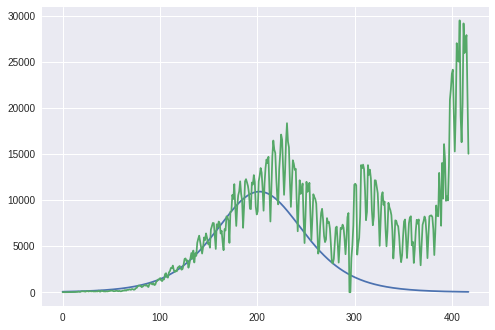

In [194]:
res = sech_sir(xdata,popt[0],popt[1],popt[2])
plt.plot(xdata,res)
plt.plot(xdata,ydata)